In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

Matplotlib is building the font cache; this may take a moment.


### INPUT READING AND PROCESSING
- The database considered is not the original and it was changed for this notebook, so I'll skip all the data processing part

In [2]:
#INPUT
df=pd.read_csv('input/FILE.csv')


#GIVEN THE STANDARD TRAFFIC OF THE WEBSITE CONSIDERED, IN THIS CASE I CHOSE A TIME INTERVAL OF ONE WEEK

def intervallo(mo,da):
    mo=str(mo)
    if da>=1 and da<=7:
        s=mo+'_'+'w1'
    elif da>7 and da<=14:
        s=mo+'_'+'w2'
    elif da>14 and da<=21:
        s=mo+'_'+'w3'
    elif da>21:
        s=mo+'_'+'w4'
    return s

df['intervallo']=df.apply(lambda x: intervallo(x.month, x.day), axis=1)
df.columns=['Client ID','Total Engagement Time','Channel','month','day','Time_range']

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


len del database:  2991350


### OVERVIEW OF THE DATABASE CONSIDERED

In [8]:
df

,Client ID,Total Engagement Time,Channel,month,day,Time_range
0,333421,0,Referral,1,31,1_w4
1,333421,0,Referral,1,28,1_w4
3,333421,0,Referral,2,1,2_w1
7,645892,501,Direct,4,30,4_w4
8,333421,0,Referral,1,10,1_w2
...,...,...,...,...,...,...
2991313,452486,26,Direct,6,21,6_w3
2991314,452486,401,Direct,6,21,6_w3
2991327,452510,30,Organic Search,6,22,6_w4
2991328,452546,2072,Organic Search,6,14,6_w2


### CREATION OF THE PATH FOR EACH CLIENTS DURING A SPECIFIC TIME INTERVAL

In [43]:
#WEEKS
paths={}
for inter in df['Time_range'].unique():
    this_period=df[df['Time_range']==inter]
    for cl in this_period['Client ID'].unique():
        this_cl=this_period[this_period['Client ID']==cl]
        this_cl=this_cl.sort_values(by='day')
        path=this_cl['Channel'].tolist()
        key=str(cl)+'_'+str(inter)
        paths[key]=path
paths.keys()
dd=pd.DataFrame()
dd['ID']=list(paths.keys())
dd['path']=list(paths.values())

### PATH DEFINITION
- The path is composed by a sequence of channels that refect the landing pages subsequently visited by the client during the time range defined

In [9]:
dd

,Unnamed: 0,ID,path
0,0,333421_1_w4,"['Referral', 'Referral', 'Referral', 'Referral']"
1,1,861967_1_w4,"['Organic Search', 'Organic Search', 'Organic ..."
2,2,610908_1_w4,"['Organic Search', 'Organic Search', 'Referral..."
3,3,390312_1_w4,"['Direct', 'Direct', 'Direct', 'Direct', 'Dire..."
4,4,222069_1_w4,"['Organic Search', 'Organic Search', 'Organic ..."
...,...,...,...
1166404,1166404,428912_8_w2,['Organic Search']
1166405,1166405,437453_8_w2,"['Organic Search', 'Organic Search']"
1166406,1166406,443821_8_w2,['Direct']
1166407,1166407,444168_8_w2,['Direct']


### MARKOV CHAIN CLASS DEFINITION

In [10]:

class MARKOV:
    '''
    Input type: list of lists

    Receives in Input a list of paths
    Returns as output a transition matrix and a dictionary of transition probabilities
    
    '''
    
    def __init__(self,list_of_paths):
        self.list_of_paths=list_of_paths
    
    def transition_states(self):
        distinct_channels = set(x for element in self.list_of_paths for x in element)
        transition_states = {x + '------->' + y: 0 for x in distinct_channels for y in distinct_channels}

        for possible_state in distinct_channels:
            if possible_state not in ['Null']:
                for user in list_of_paths:
                    if possible_state in user:
                        indices = [i for i, state in enumerate(user) if possible_state in state]
                        for col in indices:
                            transition_states[user[col] + '------->' + user[col + 1]] += 1

        return transition_states
    
    def transition_prob(self,trans_dict):
        distinct_channels = set(x for element in self.list_of_paths for x in element)
        trans_prob = defaultdict(dict)
        for state in distinct_channels:
            if state not in ['Null']:
                counter = 0
                index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
                for col in index:
                    if trans_dict[list(trans_dict)[col]] > 0:
                        counter += trans_dict[list(trans_dict)[col]]
                for col in index:
                    if trans_dict[list(trans_dict)[col]] > 0:
                        state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                        trans_prob[list(trans_dict)[col]] = state_prob

        return trans_prob

    def transition_matrix(self,transition_probabilities):
        trans_matrix = pd.DataFrame()
        distinct_channels = set(x for element in self.list_of_paths for x in element)

        for channel in distinct_channels:
            trans_matrix[channel] = 0.00
            trans_matrix.loc[channel] = 0.00
            trans_matrix.loc[channel][channel] = 1.0 if channel in ['Null'] else 0.0

        for key, value in transition_probabilities.items():
            origin, destination = key.split('>')
            trans_matrix.at[origin, destination] = value

        return trans_matrix
    
    
    def main(self):
        trans_states = self.transition_states()
        trans_prob = self.transition_prob(trans_states)
        trans_matrix = self.transition_matrix(trans_prob)
        return trans_matrix,trans_prob
    


### COMPLETE THE PATHS
- Add a Starting point (START) and an ending point (NULL) to each path
- In my case we are interested in the relation between the channels and we do not have a final conversion variable

In [11]:
#UPDATE THE PATHS
import ast
def tolist_(inpt):
    x = ast.literal_eval(inpt)
    x=[xp.strip() for xp in x]
    return x
    
dd['path_2']=dd['path'].apply(tolist_)

def add_null(inpt):
    inp=inpt.append('Null')
    return inpt
dd['path_2']=dd['path_2'].apply(add_null)

def add_start(inpt):
    inpt.insert(0, 'Start')
    return inpt
dd['path_2']=dd['path_2'].apply(add_start)
list_of_paths=dd['path_2'].tolist()
dd.drop('path',axis=1,inplace=True)

In [12]:
dd

,Unnamed: 0,ID,path_2
0,0,333421_1_w4,"[Start, Referral, Referral, Referral, Referral..."
1,1,861967_1_w4,"[Start, Organic Search, Organic Search, Organi..."
2,2,610908_1_w4,"[Start, Organic Search, Organic Search, Referr..."
3,3,390312_1_w4,"[Start, Direct, Direct, Direct, Direct, Direct..."
4,4,222069_1_w4,"[Start, Organic Search, Organic Search, Organi..."
...,...,...,...
1166404,1166404,428912_8_w2,"[Start, Organic Search, Null]"
1166405,1166405,437453_8_w2,"[Start, Organic Search, Organic Search, Null]"
1166406,1166406,443821_8_w2,"[Start, Direct, Null]"
1166407,1166407,444168_8_w2,"[Start, Direct, Null]"


### CALL THE CLASS

In [128]:
markov=MARKOV(list_of_paths)
trans_matrix,trans_prov=markov.main()
trans_matrix

,Display,Email,Null,Start,Direct,Paid Search,(Other),Referral,Organic Search,Social
Display,0.127536,0.000000,0.854815,0.0,0.001670,0.000241,0.000056,0.009836,0.005196,0.000650
Email,0.000000,0.737069,0.219828,0.0,0.012931,0.000000,0.000000,0.012931,0.008621,0.008621
Null,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Start,0.039563,0.000045,0.000000,0.0,0.155011,0.024447,0.000809,0.041663,0.724106,0.014356
Direct,0.000437,0.000010,0.565291,0.0,0.391890,0.000680,0.000102,0.009230,0.031996,0.000364
Paid Search,0.000202,0.000000,0.597090,0.0,0.003826,0.300476,0.000000,0.019957,0.078209,0.000239
(Other),0.002037,0.000000,0.657162,0.0,0.014936,0.000000,0.291242,0.006110,0.025119,0.003394
Referral,0.003297,0.000018,0.479069,0.0,0.020674,0.010507,0.000092,0.376876,0.107814,0.001653
Organic Search,0.000237,0.000002,0.617260,0.0,0.005172,0.005978,0.000037,0.010702,0.360162,0.000449
Social,0.001397,0.000045,0.764207,0.0,0.002389,0.000180,0.000180,0.007076,0.022444,0.202082


In [131]:
trans_prov

defaultdict(dict,
            {'Display>Display': 0.12753558636304585,
             'Display>Null': 0.8548150622645361,
             'Display>Direct': 0.0016702856188408218,
             'Display>Paid Search': 0.0002412634782770076,
             'Display>(Other)': 5.567618729469406e-05,
             'Display>Referral': 0.009836126422062616,
             'Display>Organic Search': 0.005196444147504779,
             'Display>Social': 0.0006495555184380974,
             'Email>Email': 0.7370689655172413,
             'Email>Null': 0.21982758620689655,
             'Email>Direct': 0.01293103448275862,
             'Email>Referral': 0.01293103448275862,
             'Email>Organic Search': 0.008620689655172414,
             'Email>Social': 0.008620689655172414,
             'Start>Display': 0.039563309268018335,
             'Start>Email': 4.458127466437588e-05,
             'Start>Direct': 0.15501080667244507,
             'Start>Paid Search': 0.02444682782797458,
             'Start>(Other

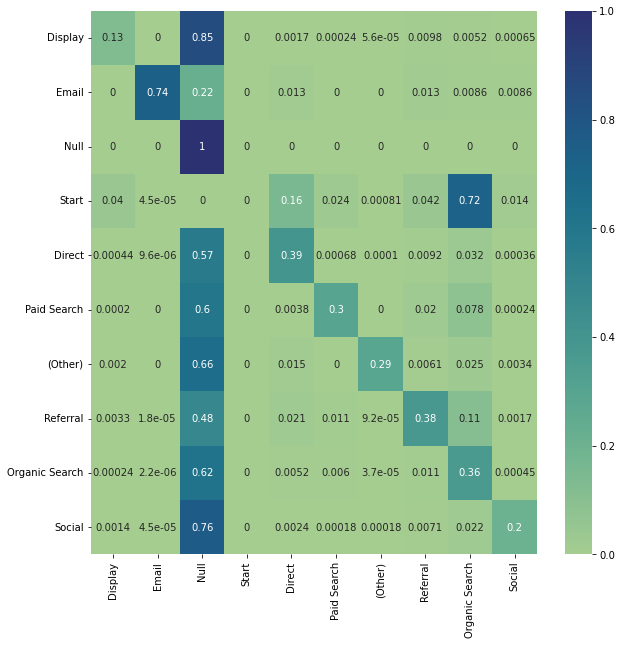

In [129]:
data = trans_matrix

yticks = data.index
keptticks = yticks[::int(len(yticks)/10)]
yticks = ['' for y in yticks]
yticks[::int(len(yticks)/10)] = keptticks

xticks = data.columns
keptticks = xticks[::int(len(xticks)/10)]
xticks = ['' for y in xticks]
xticks[::int(len(xticks)/10)] = keptticks

fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(data,linewidth=0,yticklabels=yticks,xticklabels=xticks,cmap='crest',annot=True)

# This sets the yticks "upright" with 0, as opposed to sideways with 90.
plt.yticks(rotation=0) 

plt.show()